# Practical 1

In [ ]:
''' 
Aim:
    Apply data cleaning techniques on any dataset (e.g., Paper Reviews dataset in UCI repository).
    Techniques may include:
    1. handling missing values.
    2. outliers and inconsistent values.
    3. A set of validation rules can be prepared based on the dataset and validations can be performed.
'''

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

In [2]:
df = sns.load_dataset("titanic")

# overview of the dataset
print(df.head())
print(df.shape)
print(df.dtypes)
print(df.isnull().sum()) # isna() can also be used


   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
(891, 15)
survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          ca

In [3]:
# Handling missing values using SimpleImputer
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Fill numeric missing values with mean
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Categorical columns → Fill missing with mode
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Missing values after cleaning:
 survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64


/var/folders/rk/fh9627n57c1g41k8v2ghkzvm0000gn/T/ipykernel_79540/575989710.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


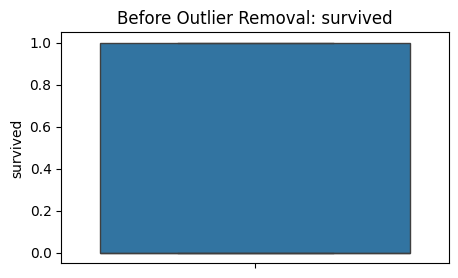

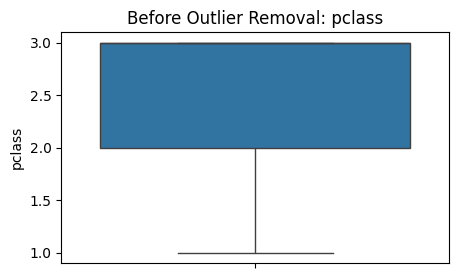

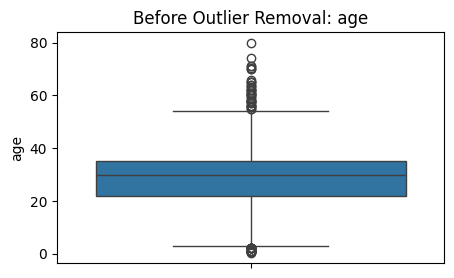

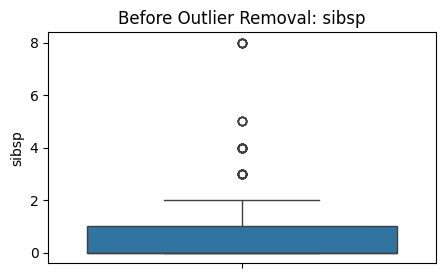

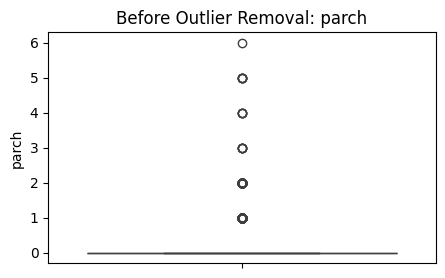

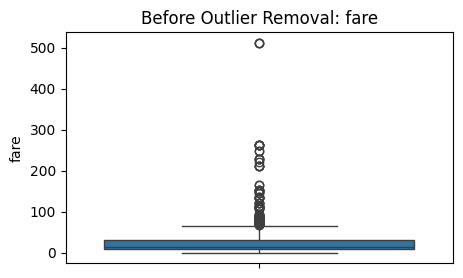

In [4]:

# Detecting outliers using Isolation Forest

# Visualize before removal
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(df[col])
    plt.title("Before Outlier Removal: " + col)
    plt.show()


In [5]:
# Isolation Forest for outlier detection
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso.fit_predict(df[numeric_cols])
df['outlier'] = outlier_labels
print("\nOutlier summary (-1 = outlier, 1 = normal):\n", df['outlier'].value_counts())


Outlier summary (-1 = outlier, 1 = normal):
 outlier
 1    846
-1     45
Name: count, dtype: int64


In [6]:
# Remove outliers
df = df[df['outlier'] == 1].drop(columns=['outlier'])
print("\n Outliers removed. Remaining records: ", len(df))


 Outliers removed. Remaining records:  846


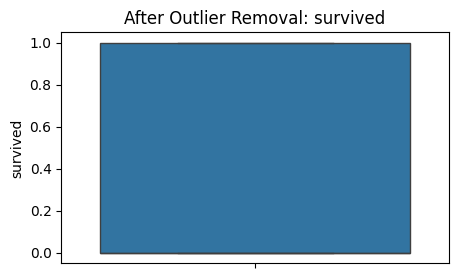

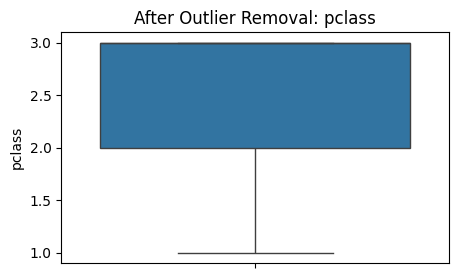

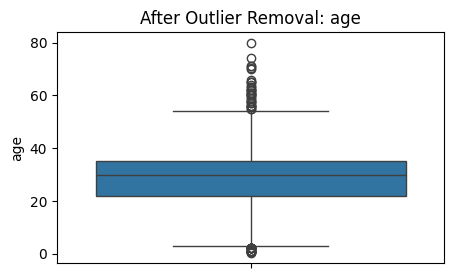

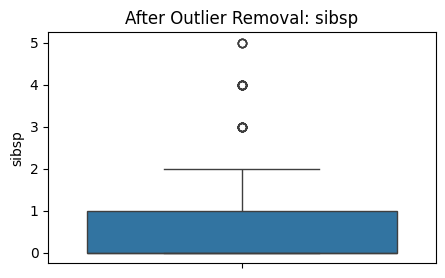

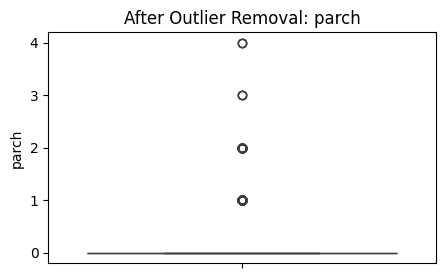

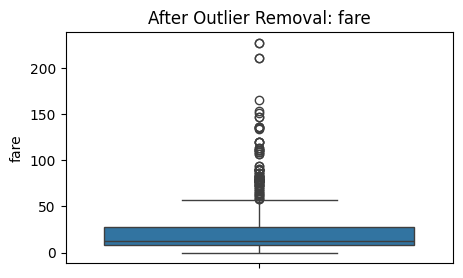

In [11]:
# Visualize after removal
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(df[col])
    plt.title("After Outlier Removal: "+ col)
    plt.show()

In [9]:
# Step 4: Fix Inconsistent Values
# -----------------------------------------
# Normalize categorical text (strip spaces, lowercase)
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

print("\nUnique values in 'sex' and 'embarked' after normalization:")
print("sex:", df['sex'].unique())
print("embarked:", df['embarked'].unique())


Unique values in 'sex' and 'embarked' after normalization:
sex: ['male' 'female']
embarked: ['s' 'c' 'q']


In [ ]:
# Step 5: Validation Rules
# -----------------------------------------
def validate_rules(df):
    invalid_rows = pd.DataFrame()

    # Rule 1: Age should be between 0 and 100
    invalid_age = df[(df['age'] < 0) | (df['age'] > 100)]

    # Rule 2: Fare should be positive
    invalid_fare = df[df['fare'] < 0]

    # Rule 3: Pclass should be in [1, 2, 3]
    invalid_pclass = df[~df['pclass'].isin([1, 2, 3])]

    invalid_rows = pd.concat([invalid_age, invalid_fare, invalid_pclass])
    return invalid_rows

invalid_data = validate_rules(df)

if invalid_data.empty:
    print("\n All rows passed validation rules.")
else:
    print("\n Invalid rows detected:\n", invalid_data)


 All rows passed validation rules.


In [16]:
# Step 6: Save Cleaned Dataset
# -----------------------------------------
df.to_csv("../dataset/cleaned_titanic_dataset.csv", index=True)
print("\n Cleaned dataset saved as 'dataset/cleaned_titanic_dataset.csv'")


 Cleaned dataset saved as 'dataset/cleaned_titanic_dataset.csv'
